# German Traffic Sign Recognition

In [39]:
import os
import random 
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, losses
from sklearn.metrics import confusion_matrix, classification_report

## Data Augmentation

In [40]:
train_dir = "/kaggle/input/gtsrb-german-traffic-sign/train"
test_csv = "/kaggle/input/gtsrb-german-traffic-sign/Test.csv"
test_img_dir = "/kaggle/input/gtsrb-german-traffic-sign/Test"

In [41]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


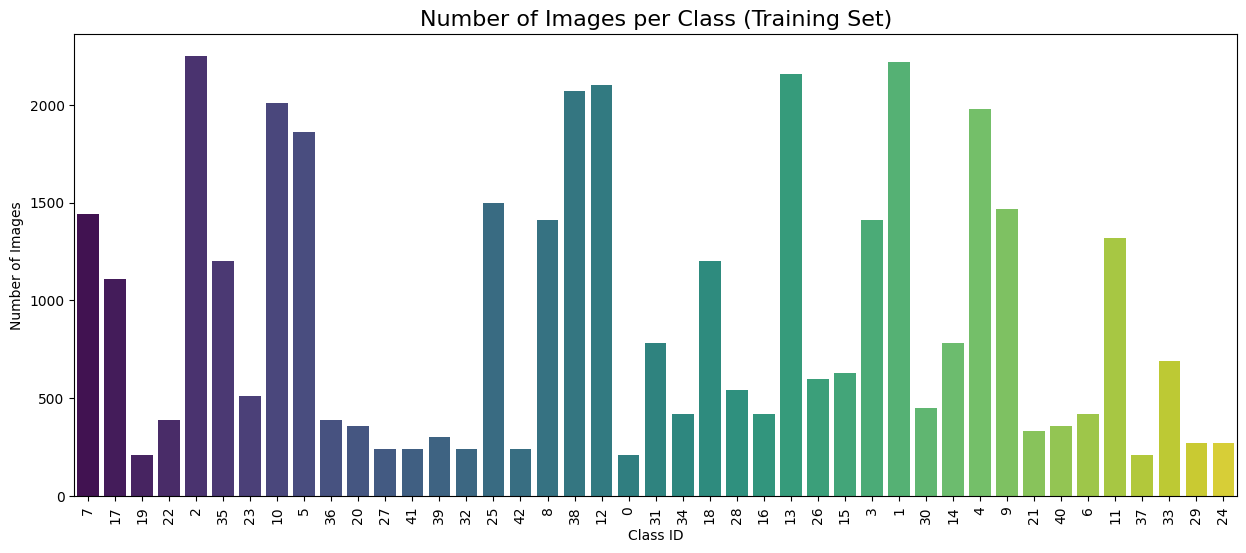

In [42]:
class_counts = {c: len(os.listdir(os.path.join(train_dir, c))) for c in os.listdir(train_dir)}

plt.figure(figsize=(15,6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
plt.title("Number of Images per Class (Training Set)", fontsize=16)
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.xticks(rotation=90)
plt.show()

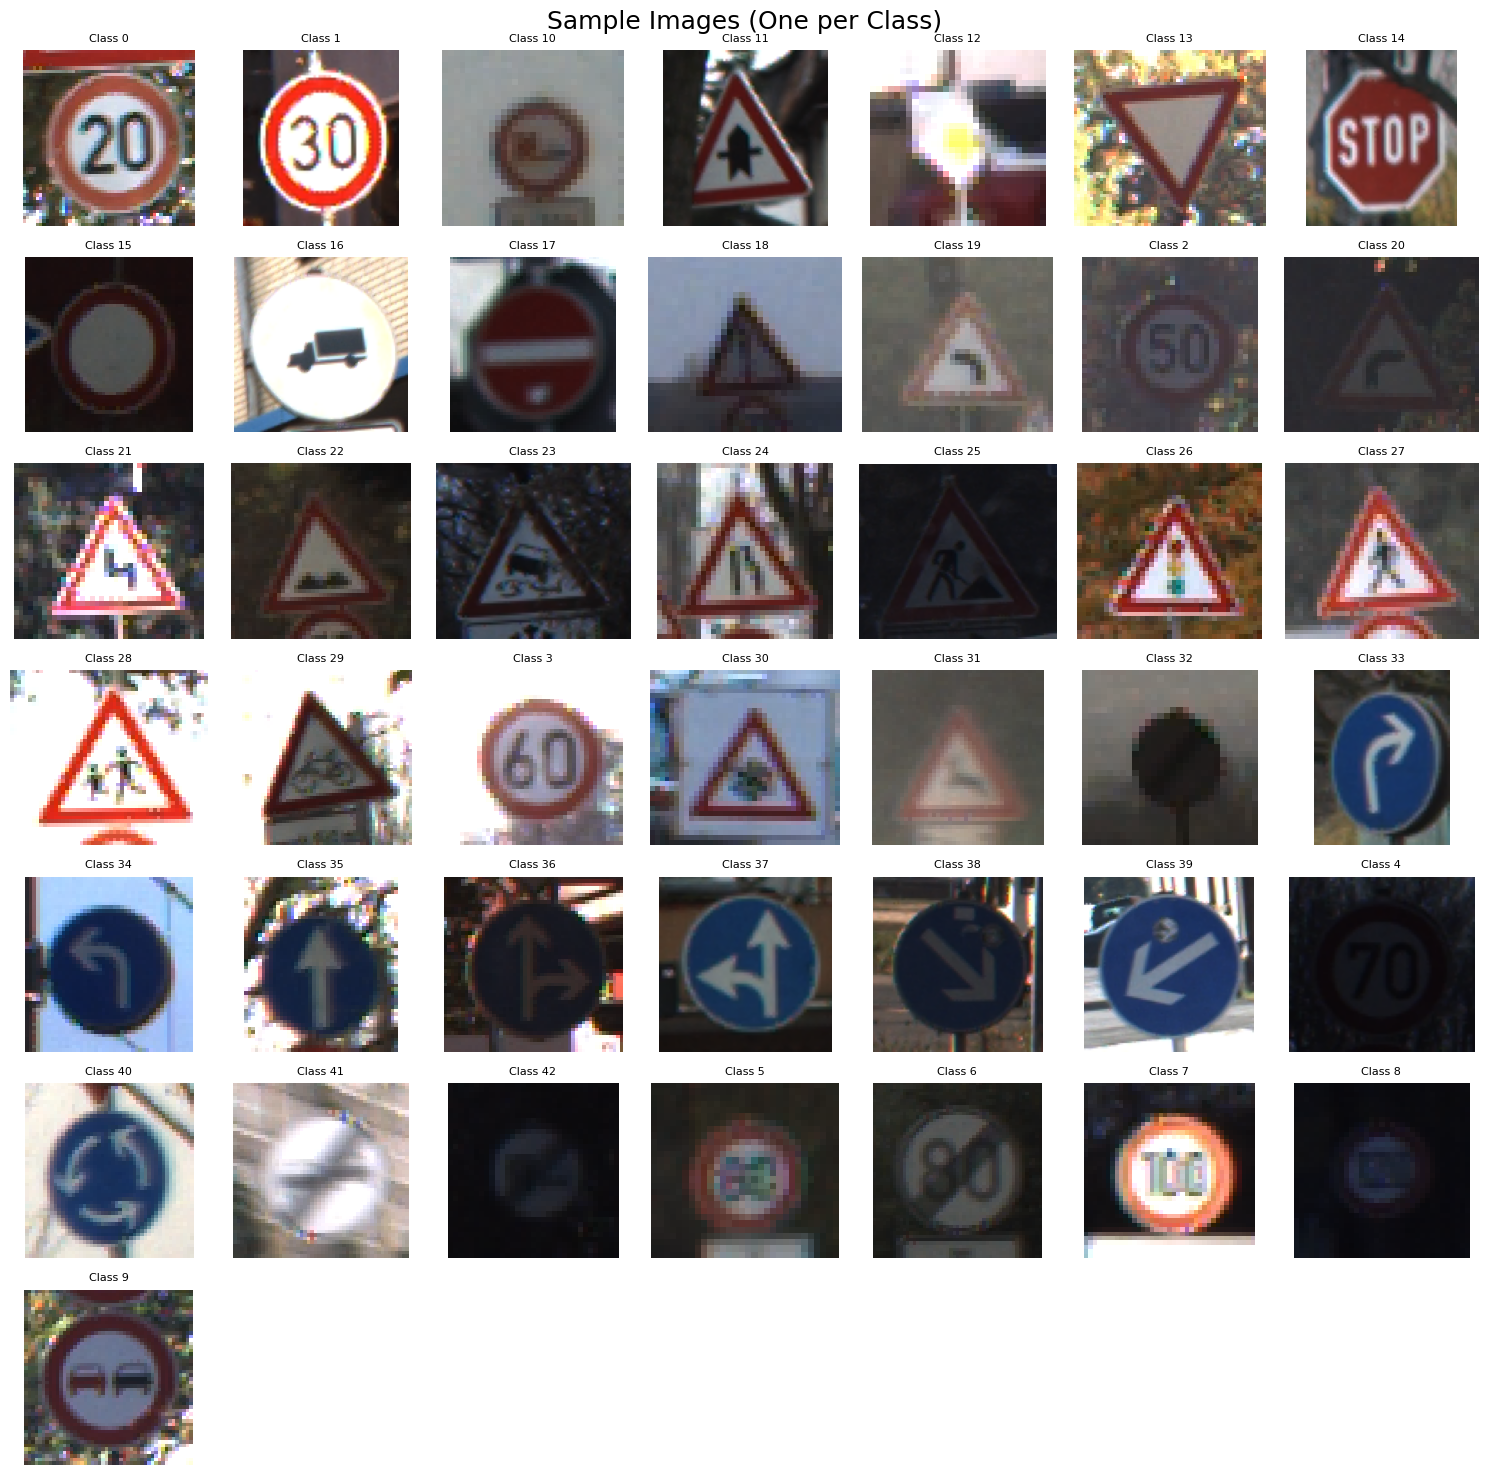

In [43]:
plt.figure(figsize=(15, 15))
rows, cols = 7, 7

for i, c in enumerate(sorted(os.listdir(train_dir))[:rows*cols]):
    class_path = os.path.join(train_dir, c)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)
    
    img = Image.open(img_path)
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Class {c}", fontsize=8)

plt.suptitle("Sample Images (One per Class)", fontsize=18)
plt.tight_layout()
plt.show()

In [44]:
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(32,32),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    seed=42,
    class_mode='categorical'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    subset='validation',
    target_size=(32,32),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    seed=42,
    class_mode='categorical'
)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


## Build  CNN Model

In [45]:
input_shape = (32,32,3)
num_classes = 43

In [46]:
## Build Model

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

In [47]:
# Compile Model
model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,451 (4.29 MB)

 Trainable params: 1,125,451 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [48]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 86s 85ms/step - accuracy: 0.4125 - loss: 2.1455 - val_accuracy: 0.8788 - val_loss: 0.4243
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 83s 85ms/step - accuracy: 0.9311 - loss: 0.2249 - val_accuracy: 0.9395 - val_loss: 0.2169
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 83s 85ms/step - accuracy: 0.9653 - loss: 0.1121 - val_accuracy: 0.9577 - val_loss: 0.1585
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 84s 86ms/step - accuracy: 0.9776 - loss: 0.0732 - val_accuracy: 0.9440 - val_loss: 0.2159
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 83s 85ms/step - accuracy: 0.9802 - loss: 0.0588 - val_accuracy: 0.9487 - val_loss: 0.2046
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 84s 85ms/step - accuracy: 0.9859 - loss: 0.0445 - val_accuracy: 0.9573 - val_loss: 0.1926
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 84s 86ms/step - accuracy: 0.9896 - loss: 0.0336 - val_accuracy: 0.9490 - val_loss: 0.2303
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 83s 85ms/step - accuracy: 0.9905 - loss: 0.0321 - val_accurac

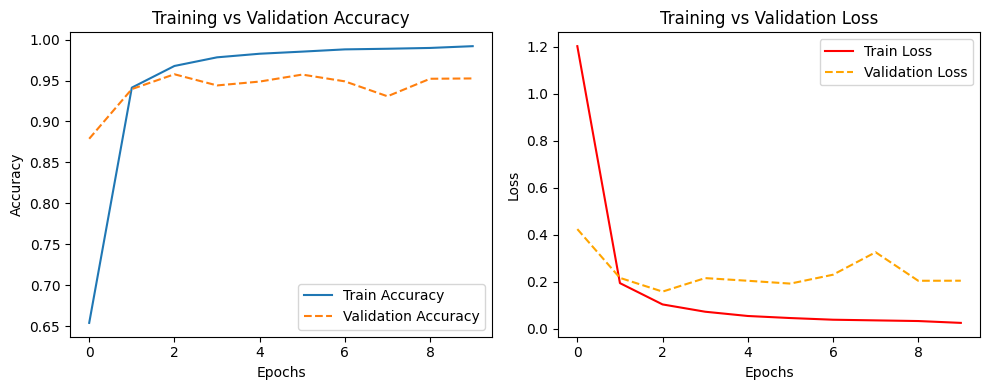

In [49]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

## Test Model

In [50]:
df = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')

In [51]:
print(df.head())

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png


In [52]:
# Create folder for structured test images
src_dir = "/kaggle/input/gtsrb-german-traffic-sign/"
test_dir = "./Dataset/Test/"
os.makedirs(test_dir, exist_ok=True)

In [53]:
!mkdir -p Dataset/Test

In [54]:
#  Copy images into class folders
for i in range(len(df)):
    label = str(df.iloc[i].ClassId)
    img_path = os.path.join(src_dir, df.iloc[i].Path)  # e.g. /kaggle/input/gtsrb-german-traffic-sign/Test/00000.png
    label_folder = os.path.join(test_dir, label)
    os.makedirs(label_folder, exist_ok=True)
    copyfile(img_path, os.path.join(label_folder, os.path.basename(df.iloc[i].Path)))

print(" Test images copied successfully!")

 Test images copied successfully!


In [55]:
# Verify structure
for c in sorted(os.listdir(test_dir))[:5]:
    print(c, "→", len(os.listdir(os.path.join(test_dir, c))), "images")

# Load test data with generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

0 → 60 images
1 → 720 images
10 → 660 images
11 → 420 images
12 → 690 images
Found 12630 images belonging to 43 classes.


In [56]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f" Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

  1/395 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.8438 - loss: 0.7272

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


395/395 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9628 - loss: 0.1680
 Test Accuracy: 96.20%
Test Loss: 0.1712


In [57]:
#  Predictions
y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

395/395 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step


In [58]:
# Classification report
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred_classes, digits=4))

📊 Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.8333    0.9091        60
           1     0.9760    0.9597    0.9678       720
           2     1.0000    0.9909    0.9954       660
           3     0.9756    0.9500    0.9626       420
           4     0.9700    0.9826    0.9762       690
           5     0.9917    0.9931    0.9924       720
           6     0.9926    1.0000    0.9963       270
           7     0.9457    0.9952    0.9698       210
           8     0.9932    0.9800    0.9866       150
           9     1.0000    0.9889    0.9944       360
          10     0.9537    0.8974    0.9247       390
          11     0.8955    1.0000    0.9449        60
          12     0.8849    0.9840    0.9318       750
          13     0.8000    0.9778    0.8800        90
          14     0.7973    0.6556    0.7195        90
          15     0.9298    0.8833    0.9060       120
          16     0.9927    0.9067    0.9477       150
 

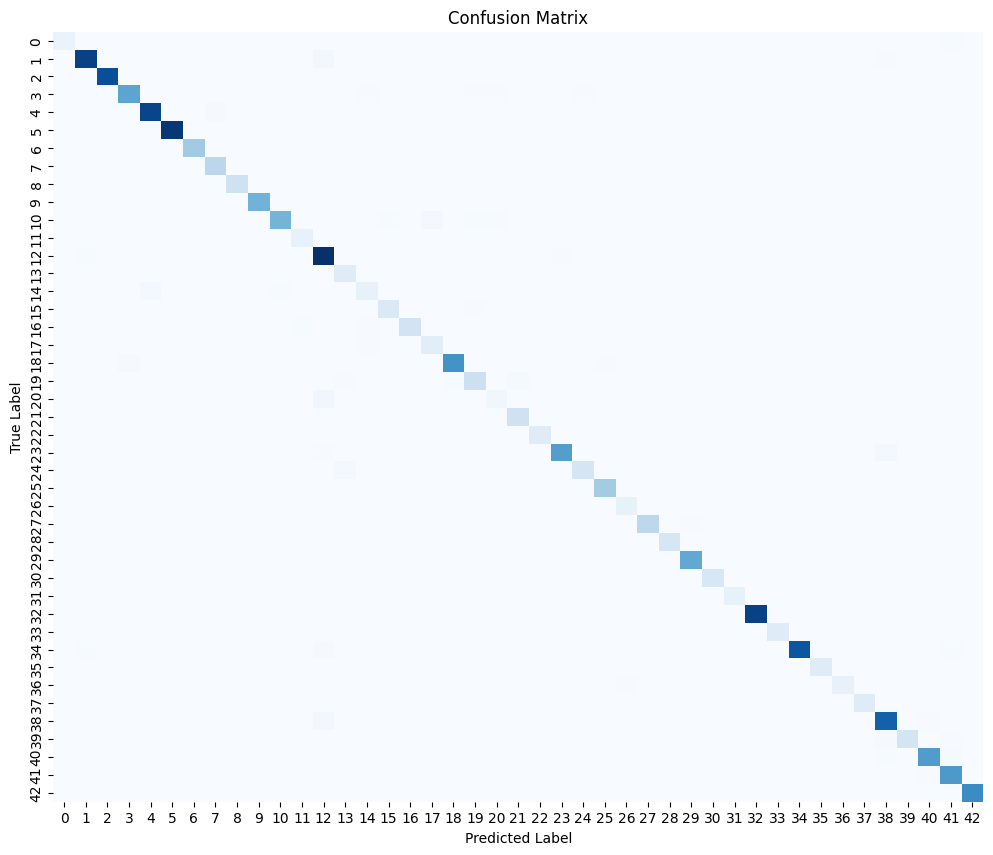

In [59]:
#  Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


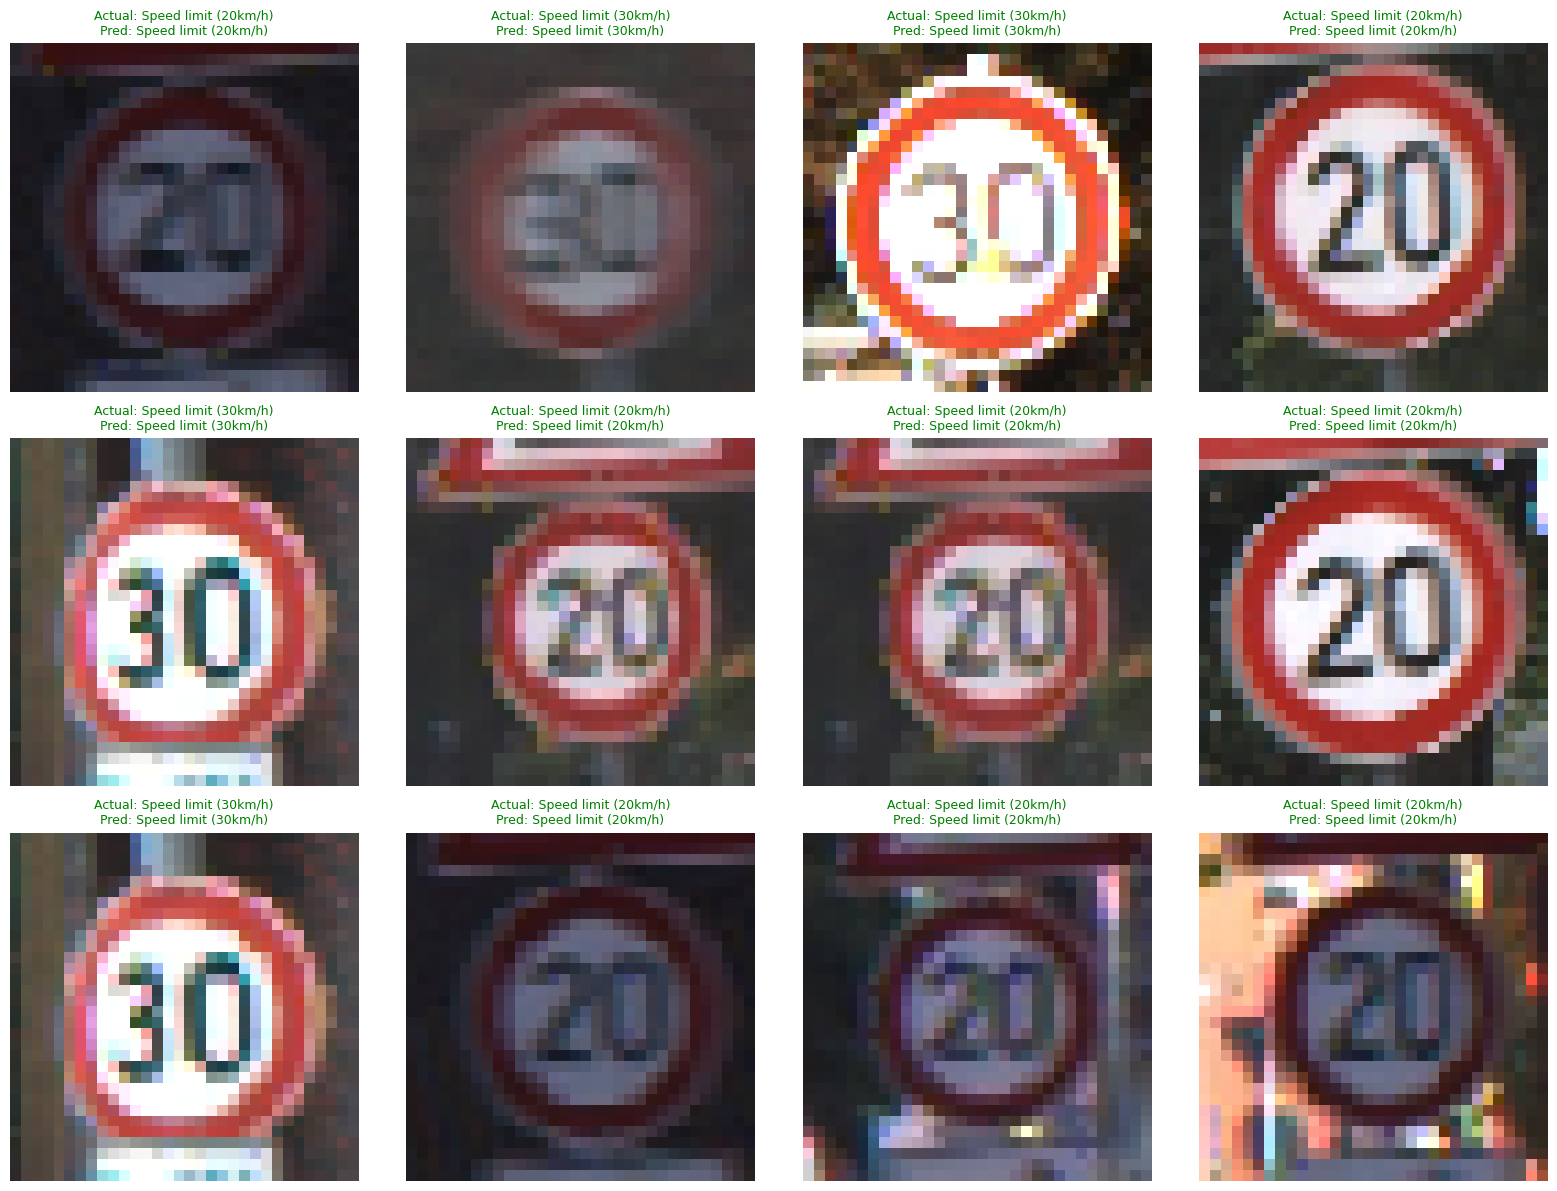

In [61]:
import random as rn

val_images, val_labels = next(test_generator)
predicted = model.predict(val_images)
y_pred = np.argmax(predicted, axis=-1)
y_true = np.argmax(val_labels, axis=-1)

fig, ax = plt.subplots(3, 4, figsize=(16, 12))
for i in range(3):
    for j in range(4):
        idx = rn.randint(0, len(val_images) - 1)
        ax[i, j].imshow(val_images[idx])
        ax[i, j].axis('off')
        actual = list(classes.values())[y_true[idx]]
        pred = list(classes.values())[y_pred[idx]]
        color = 'green' if y_true[idx] == y_pred[idx] else 'red'
        ax[i, j].set_title(f"Actual: {actual}\nPred: {pred}", color=color, fontsize=9)

plt.tight_layout()
plt.show()

